In [36]:
import skimage
from skimage import io, measure, color
import IPython
import matplotlib.pyplot as plt
from copy import copy
from skimage.color import rgb2gray
from time import sleep
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [48]:
img1 = io.imread('/home/anya/ipython/images_processing/Archive/Klad00.jpg')
img2 = io.imread('/home/anya/ipython/images_processing/Archive/Klad01.jpg')
img3 = io.imread('/home/anya/ipython/images_processing/Archive/Klad02.jpg')
money = io.imread('/home/anya/ipython/images_processing/Archive/money.jpg')

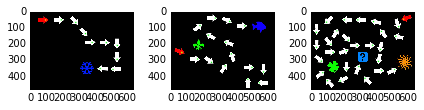

In [4]:
io.imshow_collection([img1, img2, img3])

# 1

In [5]:
def to_binary(img, threshold=0.05, show=True):
    img = rgb2gray(img) > threshold
    
    if show:
        plt.imshow(img, cmap='gray')
        plt.show()
    return img

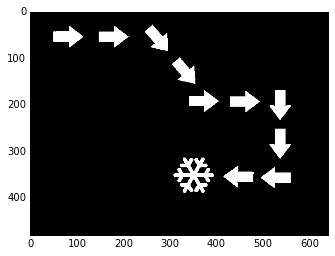

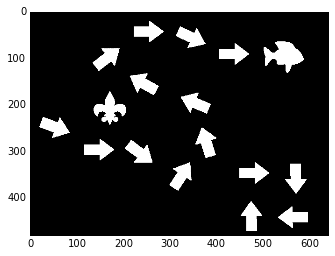

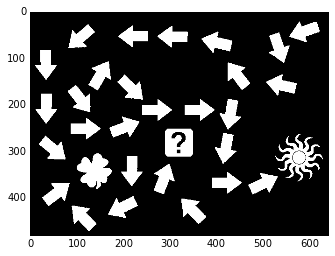

In [6]:
imgb1, imgb2, imgb3 = map(lambda img: to_binary(img), [img1, img2, img3])

# 2

In [7]:
def allocate_related_components(img, show=True):
    components = skimage.measure.label(img)
    
    if show:
        plt.imshow(components + (components > 0.))
        plt.show()
    return components

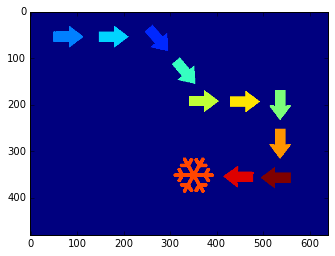

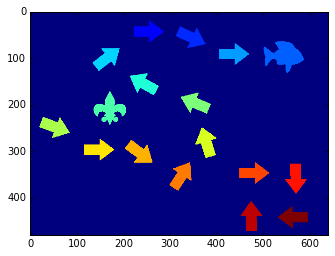

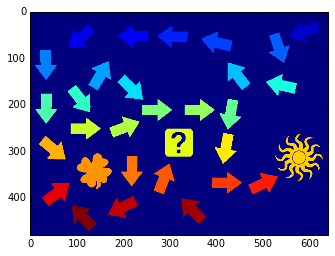

In [8]:
components = map(allocate_related_components, [imgb1, imgb2, imgb3])

# 3

In [9]:
def find_arrows(components, eccentricity_threshold=0.84, show=True, return_labels=False):
    labels = measure.regionprops(components)
    arrows_labels = [labels[i].label for i in range(len(labels)) 
                       if labels[i].eccentricity > eccentricity_threshold]
    
    arrows = copy(components)
    for i in range(arrows.shape[0]):
        for j in range(arrows.shape[1]):
            arrows[i][j] = arrows[i][j] in arrows_labels
    
    if show:
        plt.figure(figsize=(8,16))
        ax1 = plt.subplot(121)
        ax1.imshow(arrows * components)

        ax2 = plt.subplot(122)
        ax2.imshow(components)
        plt.show()
    
    if not return_labels:
        return arrows * components
    else:
        return arrows * components, arrows_labels

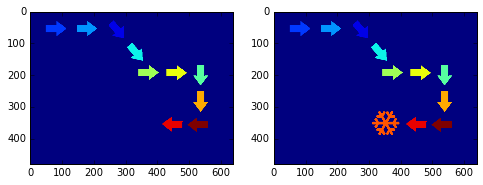

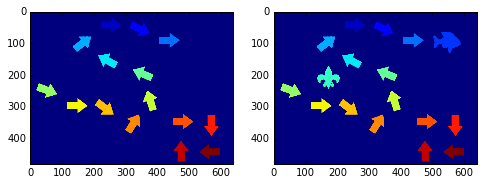

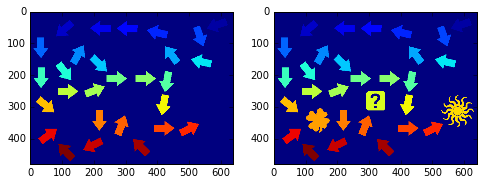

In [10]:
arrows = map(find_arrows, components)

# 4

In [11]:
def find_start_arrow(args, show=True):
    img, arrows = args
    colored_img = (img[:,:,0] > 50) * (img[:,:,2] < 50) * (arrows > 0)
    
    if show:
        plt.figure(figsize=(10,20))
        ax1 = plt.subplot(121)
        ax1.imshow(colored_img, cmap='gray')
        ax2 = plt.subplot(122)
        ax2.imshow(img)
        plt.show()
    return colored_img 

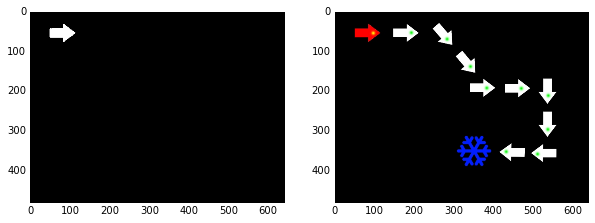

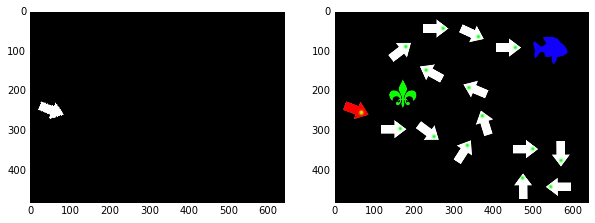

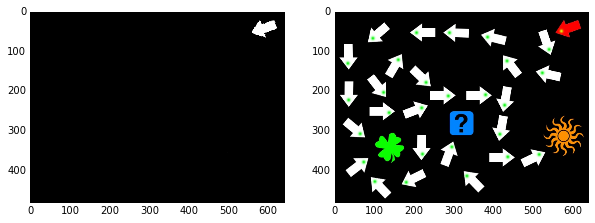

In [12]:
col_imgs = map(find_start_arrow, zip([img1, img2, img3], arrows))

# 5

In [17]:
def find_next_item(img, components, label, epsilon=1., show=True):
    
    #find green points in the arrows
    points = (img[:,:,1] > 50) * (img[:,:,2] < 50) * 100 * (components > 0)
    props = measure.regionprops(components, points + (components > 0))
    next_items = dict()
    
    for prop in props:
        if prop.label == label:
            break

    centr_y, centr_x = prop.centroid
    weighed_centr_y, weighted_centr_x = prop.weighted_centroid

    #line to the next arrow: y = ax + b
    def f_line(x):
        return max(0., min(- (weighed_centr_y -centr_y) * (weighted_centr_x - x) / \
                (weighted_centr_x - centr_x) + weighed_centr_y, img.shape[0] - 1))

    #print "prop.orientation: {}, prop.angle {}".format(prop.orientation, prop.angle)
    if centr_x < weighted_centr_x:
        x_range = range(int(weighted_centr_x), img.shape[1])
    else:
        x_range = range(int(weighted_centr_x), -1, -1)

    next_label = 0.
    for x in x_range:
        y = f_line(x)
        if y < components.shape[0] and components[y][x] != 0 and components[y][x] != prop.label:
            next_label = components[y][x]
            next_items[prop.label] = next_label
            break
        
    if show:
        plt.figure(figsize=(12,36))
        ax1 = plt.subplot(121)
        ax1.imshow(components)
        ax1.plot(x_range, map(f_line, x_range), color='r')
        ax2 = plt.subplot(122)
        ax2.imshow((components == next_label) + (components == prop.label))
        plt.show()
        
    return next_label

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


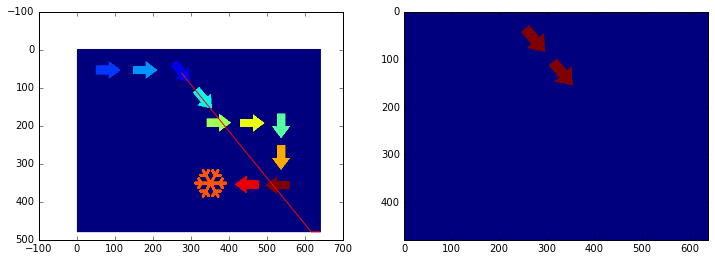

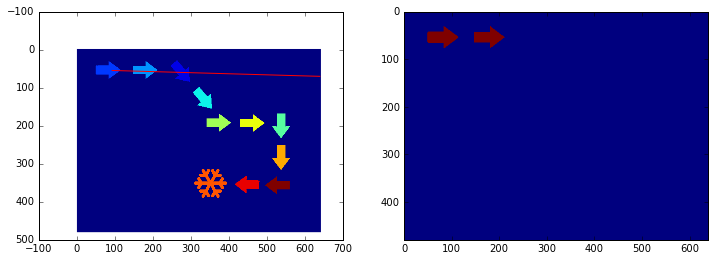

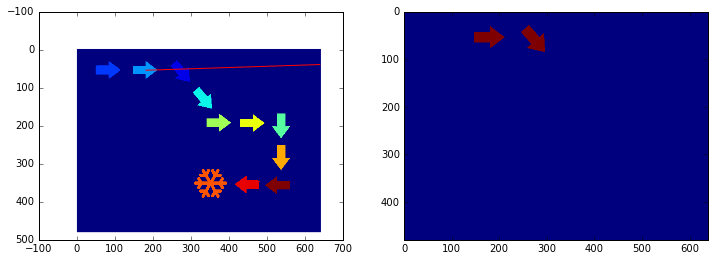

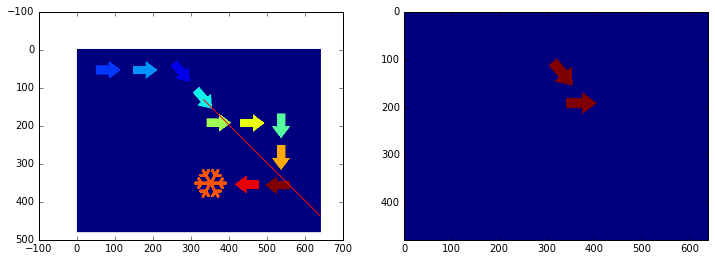

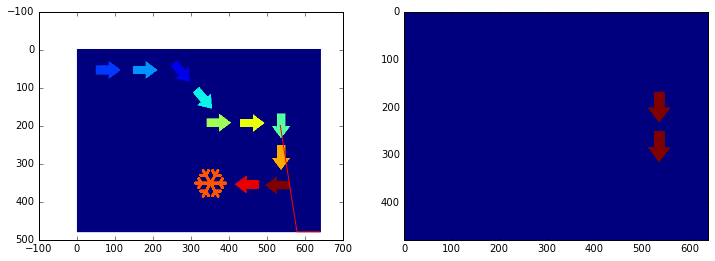

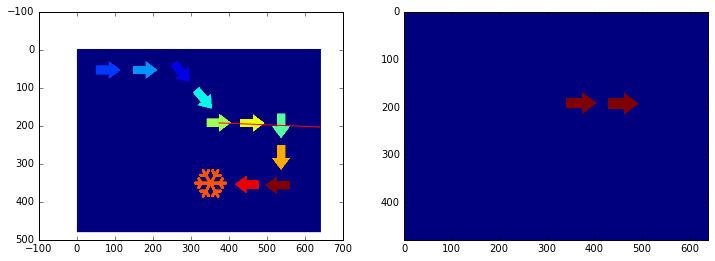

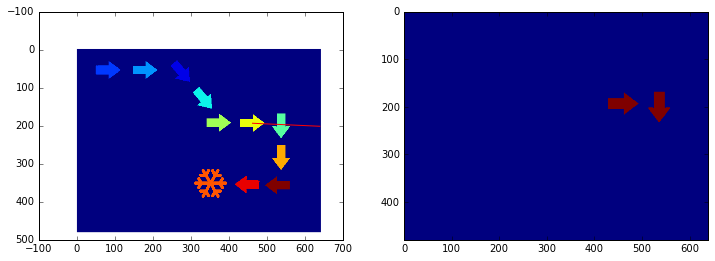

In [18]:
for i in range(1, 8):
    find_next_item(img1, components[0], i)

# 6

In [75]:
def find_the_treasuse(img, movie_mode=False):

    imgb = to_binary(img, show=False)
    components = allocate_related_components(imgb, show=False)
    arrows, arrows_labels = find_arrows(components, show=False, return_labels=True)
    start_arrow = find_start_arrow((img, arrows), show=False) * components
    
    current_label = list(set(np.ravel(start_arrow).tolist()) - {0,})[0]
    passed_labels = [current_label,]
    passed_way = np.zeros_like(components)
    step_number=0
    
    while current_label in arrows_labels:
        passed_way += components == current_label
        
        if movie_mode:
            IPython.display.clear_output(wait=True)

        plt.imshow(components * passed_way)
        plt.show()
        
        passed_labels.append(current_label)
        current_label = find_next_item(img, components, current_label, show=False)
        step_number += 1
        sleep(1)
    
    if movie_mode:
        IPython.display.clear_output(wait=True)
    
    passed_way += components == current_label
    plt.imshow(components * passed_way)
    plt.show()
    
    if movie_mode:
        sleep(1)
        IPython.display.clear_output(wait=True)
        fig = plt.imshow(money)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.show()

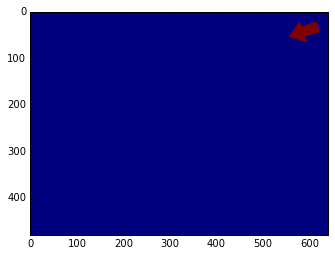

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


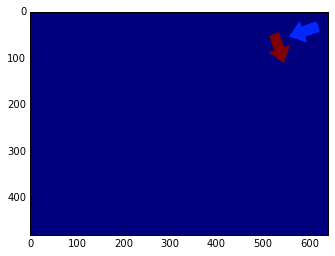

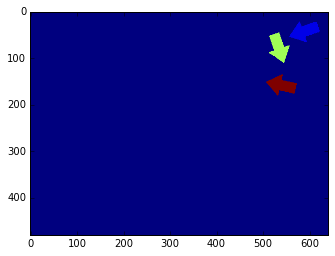

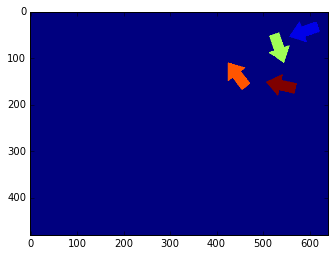

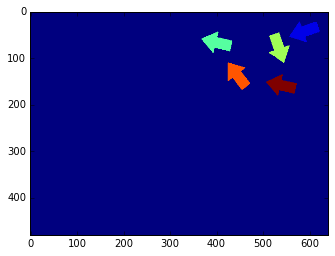

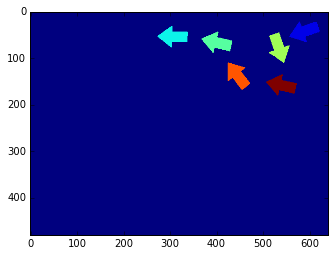

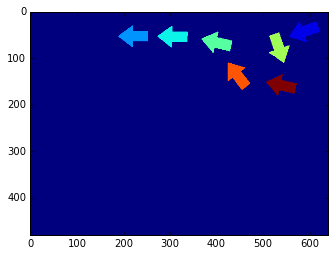

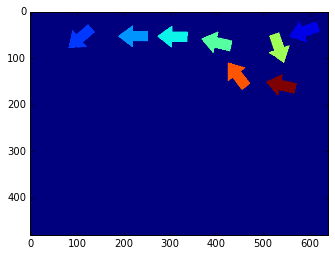

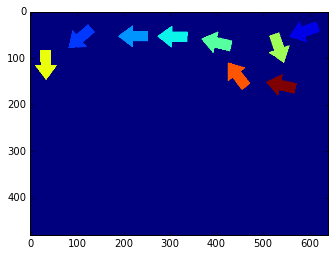

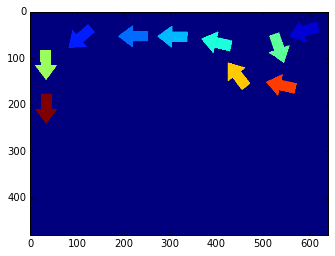

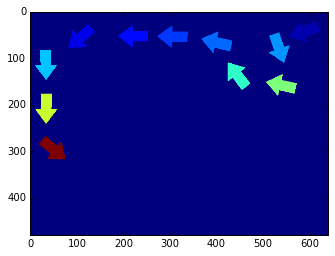

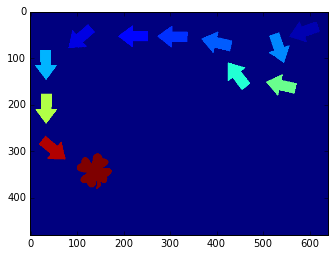

In [74]:
find_the_treasuse(img3, movie_mode=False)

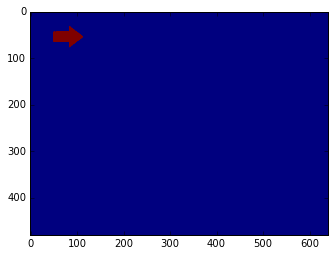

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


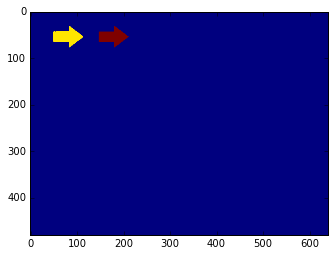

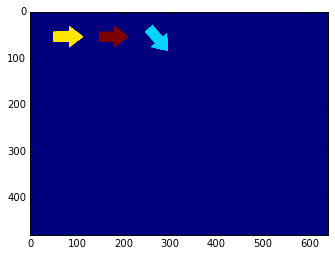

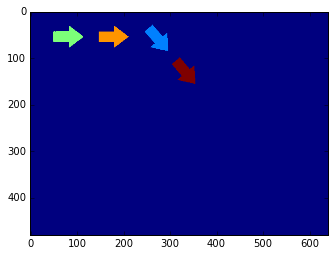

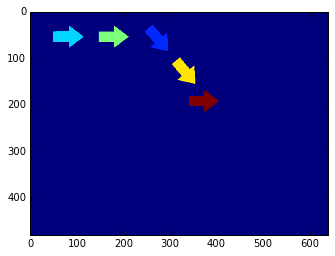

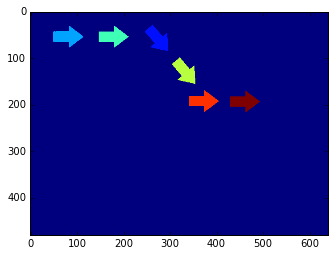

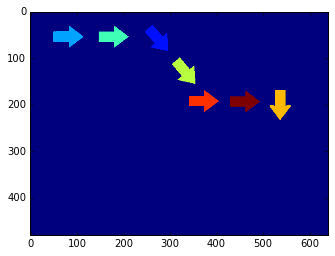

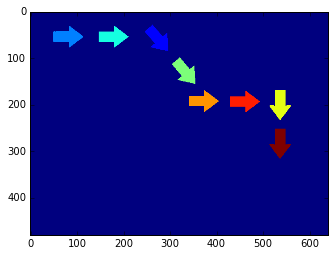

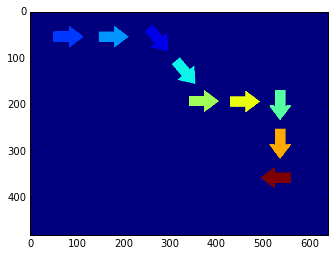

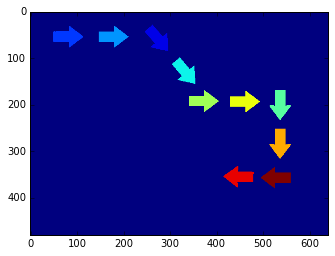

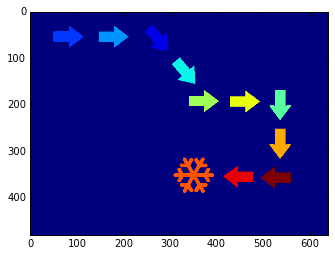

In [77]:
find_the_treasuse(img1, movie_mode=False)

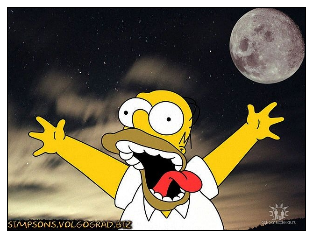

In [76]:
find_the_treasuse(img2, movie_mode=True)